In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import f1_score as f1

*Импортируем датасет преобразованный в.csv*

In [ ]:
!wget https://www.dropbox.com/s/bw7vcwdse226vr4/data.csv

In [8]:
df = pd.read_csv('data.csv',sep=';')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (1,9,28,46) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [9]:
#удаляем лишние пробелы из названия колонок

df.columns = df.columns.str.replace(' ', '')

ОПРЕДЕЛЯЕМ ОСНОВНЫЕ ДАТЧИКИ, КОТОРЫЕ ПОДВЕРГАЮТСЯ АТАКАМ

#Загружаем файл со списком атак 

In [11]:
!wget https://www.dropbox.com/s/ric1yxd389ypv67/List_of_attacks_Final.xlsx

--2022-05-18 22:16:18--  https://www.dropbox.com/s/ric1yxd389ypv67/List_of_attacks_Final.xlsx
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ric1yxd389ypv67/List_of_attacks_Final.xlsx [following]
--2022-05-18 22:16:19--  https://www.dropbox.com/s/raw/ric1yxd389ypv67/List_of_attacks_Final.xlsx
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucce14c7abc4dacc26b76f8c20b0.dl.dropboxusercontent.com/cd/0/inline/BliYNJmdUhV4GXD4wLnKYMYx9Vu99DEsrh0K8NqmxFJfWjZn3JNmkj_cex0miD911AT36IQScH3GNklEsZPk6YaYAM9lHa3mfS5hzpiLNqKnq7RVXQDGx1aJpVNMtNM7Tcp7oFXeMNn4B4nAlYa_3Y-aYKottKtZvftiCf9TnypRaA/file# [following]
--2022-05-18 22:16:19--  https://ucce14c7abc4dacc26b76f8c20b0.dl.dropboxusercontent.com/cd/0/inline/BliYNJmdUhV4GXD4wLnKYMYx9V

In [12]:
#Чтение файла

df2 = pd.read_excel('List_of_attacks_Final.xlsx')
df2 = df2.drop(df2[df2['Attack Point'].isna() == True].index)

In [13]:
#Удаляем строки No Physical Impact Attack

df2 = df2.drop(df2[df2['Attack Point'] == 'No Physical Impact Attack'].index)

In [14]:
#Получаем список уникальных значений из колонки Attack Point

print("количество датчиков, которые подвергаются атакам", len(df2['Attack Point'].unique()))
print()
print("Список датчиков")
print(df2['Attack Point'].unique())

количество датчиков, которые подвергаются атакам 28

Список датчиков
['MV-101' 'P-102' 'LIT-101' 'MV-504' 'AIT-202' 'LIT-301' 'DPIT-301'
 'FIT-401' 'MV-304' 'Mv-303' 'MV-303' 'AIT-504' 'MV-101, LIT-101'
 'UV-401, AIT-502, P-501' 'P-602, DIT-301, MV-302' 'P-203, P-205'
 'LIT-401, P-401' 'P-101, LIT-301' 'P-302, LIT-401' 'P-302'
 'P-201, P-203, P-205' 'LIT-101, P-101, MV-201' 'LIT-401' 'P-101'
 'P-101; P-102' 'P-501, FIT-502' 'AIT-402, AIT-502' 'FIT-401, AIT-502']


*Совмещаем значения по пробелу и добавляем в новый чистый список*

In [15]:

features = []

for col in df2['Attack Point'].unique():
    features += col.split(', ')

#уберем символ "-" из названия фичей и сделаем все буквы заглавными

for i in range(len(features)):
    features[i] = features[i].replace('-', "")
    features[i] = features[i].upper()
    
features = list(set(features))

In [16]:
#удалим фичи которых нет в тренировочном наборе данных

for i in features:
    if i not in df.columns:
        features.remove(i)

In [17]:
#создадим новый датафрейм в котором будут только фичи из списка features

df_new = pd.DataFrame()

for colname in features:
    df_new[colname] = df[colname].copy()

In [18]:
#Добавим к датасету целевую переменную, чтобы в случае удаления лишних строк, длины тренировочного набора и серия с меткой совпали

df_new['Normal/Attack'] = df['Normal/Attack'].copy()
df_new.head(5)

,LIT101,FIT502,LIT301,P203,LIT401,DPIT301,P401,MV101,MV303,MV201,...,MV304,P501,P302,AIT504,AIT402,P102,P201,P205,MV302,Normal/Attack
0,"522,8467","1,279621","956,1651",2,"942,0662","19,74838",1,2,1,2,...,1,2,2,"12,03538","156,0882",1,1,2,2,Normal
1,"522,886","1,297554","956,1651",2,"942,0277","19,74838",1,2,1,2,...,1,2,2,"12,03538","156,0882",1,1,2,2,Normal
2,"522,8467","1,293967","956,4855",2,"941,8739","19,69076",1,2,1,2,...,1,2,2,"12,03538","156,0882",1,1,2,2,Normal
3,"522,9645","1,281158","956,806",2,"941,797","19,69076",1,2,1,2,...,1,2,2,"12,03538","156,0882",1,1,2,2,Normal
4,"523,4748","1,281158","957,0864",2,"942,22","19,69076",1,2,1,2,...,1,2,2,"12,03538","156,0882",1,1,2,2,Normal


In [19]:
df_new.columns

Index(['LIT101', 'FIT502', 'LIT301', 'P203', 'LIT401', 'DPIT301', 'P401',
       'MV101', 'MV303', 'MV201', 'FIT401', 'UV401', 'AIT502', 'P602',
       'AIT202', 'P101', 'MV304', 'P501', 'P302', 'AIT504', 'AIT402', 'P102',
       'P201', 'P205', 'MV302', 'Normal/Attack'],
      dtype='object')

In [20]:
#Убираем лишние пробелы из значений целевой переменной

df_new['Normal/Attack'] = df_new['Normal/Attack'].str.replace(' ', "")

In [21]:
unique_values = []

for column in df_new.columns:
    if len(df_new[column].unique()) < 2:
        df_new = df_new.drop(column, axis=1)
        print(column)

P401


In [22]:
df_new

,LIT101,FIT502,LIT301,P203,LIT401,DPIT301,MV101,MV303,MV201,FIT401,...,MV304,P501,P302,AIT504,AIT402,P102,P201,P205,MV302,Normal/Attack
0,"522,8467","1,279621","956,1651",2,"942,0662","19,74838",2,1,2,"1,713517",...,1,2,2,"12,03538","156,0882",1,1,2,2,Normal
1,"522,886","1,297554","956,1651",2,"942,0277","19,74838",2,1,2,"1,715952",...,1,2,2,"12,03538","156,0882",1,1,2,2,Normal
2,"522,8467","1,293967","956,4855",2,"941,8739","19,69076",2,1,2,"1,715952",...,1,2,2,"12,03538","156,0882",1,1,2,2,Normal
3,"522,9645","1,281158","956,806",2,"941,797","19,69076",2,1,2,"1,71467",...,1,2,2,"12,03538","156,0882",1,1,2,2,Normal
4,"523,4748","1,281158","957,0864",2,"942,22","19,69076",2,1,2,"1,71467",...,1,2,2,"12,03538","156,0882",1,1,2,2,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449914,"519,5495","1,288971","974,5498",2,"956,8701","20,39823",2,1,2,"1,705315",...,1,2,2,"14,8039","145,6037",1,2,2,2,Normal
449915,"520,4131","1,272704","974,5898",2,"957,1777","20,39823",2,1,2,"1,705315",...,1,2,2,"14,8039","145,6037",1,2,2,2,Normal
449916,"520,6878","1,269502","974,2695",2,"957,293","20,33101",2,1,2,"1,706212",...,1,2,2,"14,8039","145,5524",1,2,2,2,Normal
449917,"520,7271","1,263866","974,2294",2,"957,6775","20,29579",2,1,2,"1,706212",...,1,2,2,"14,8039","145,5524",1,2,2,2,Normal


In [23]:
num_cols = []

for columns in df_new.columns:
    if len(df_new[columns].unique())> 3:
        num_cols += [columns]

In [24]:
for num_col in num_cols:
    df_new[num_col] = df_new[num_col].str.replace(',', '.').astype('float')

In [25]:
df_new.isna().sum()

LIT101               0
FIT502               0
LIT301               0
P203                 0
LIT401               0
DPIT301              0
MV101                0
MV303                0
MV201                0
FIT401           16384
UV401                0
AIT502               0
P602                 0
AIT202               0
P101                 0
MV304                0
P501                 0
P302                 0
AIT504               0
AIT402               0
P102                 0
P201                 0
P205                 0
MV302                0
Normal/Attack        0
dtype: int64

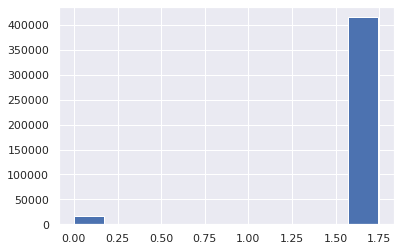

In [26]:
df_new.FIT401.hist()

In [27]:
#Как мы видим, в датасете пропущенные значения присутствуют только в колонке FIT401
#Более того, все строки, которые в колонке FIT401 содержат пропущенное значение, имеют метку Attack

print(len(df_new[df_new.FIT401.isna()]))
print(len(df_new[df_new.FIT401.isna()]['Normal/Attack'] == 'Attack'))

16384
16384


In [28]:
#Построив сводную таблицу, мы видим, что в случае когда FIT401 = 0, в подавляющм числе случаев это признак атаки

pd.pivot_table(df_new[df_new.FIT401 == 0], values='FIT401',
                    columns=['Normal/Attack'], aggfunc='count')

Normal/Attack,Attack,Normal
FIT401,16374,104


In [29]:
#А в случаях, когда FIT401 больше 0, в большинстве своем наблюдения имеют метку Normal

pd.pivot_table(df_new[df_new.FIT401 > 0], values='FIT401',
                    columns=['Normal/Attack'], aggfunc='count')

Normal/Attack,Attack,Normal
FIT401,21863,395194


In [30]:
#Исходя из вышесказанного, попробем заменить все пропущенные значения FIT401 на 0

df_new['FIT401'] = df_new['FIT401'].fillna(0)

In [31]:
#посчитаем сколько строк с меткой Normal и Attack

print(len(df_new[df_new['Normal/Attack'] == 'Attack']))
print(len(df_new[df_new['Normal/Attack'] == 'Normal']))

54621
395298


In [32]:
#Заменим в нашей целевой переменной метки Normal = 0, Attack = 1

df_new['Normal/Attack'] = df_new['Normal/Attack'].replace('Normal', 0)
df_new['Normal/Attack'] = df_new['Normal/Attack'].replace('Attack', 1)

In [33]:
X = df_new.drop('Normal/Attack', axis=1)
y = df_new['Normal/Attack']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

scaler  = MinMaxScaler()
scaler.fit_transform(X_train)

X_train_scaled = scaler.transform(X_train) 
X_test_scaled  = scaler.transform(X_test)

X_train.iloc[:, :] = X_train_scaled
X_test.iloc[:, :] = X_test_scaled

In [34]:
#@title Логистическая Регрессия{ run: "auto" }
#@markdown ### Тип Регуляризации 
penalty= 'l1' #@param [ "l2" , "l1", "none"]{type:"string"}
#@markdown ### Константа Регуларизации
regularization = 1.66 #@param {type:"slider", min:0.01, max:3, step:0.05}



LogReg = LogisticRegression(fit_intercept=True,
                            penalty=penalty,solver='saga',
                            C=regularization,
                            max_iter=100000)

LogReg.fit(X_train, y_train)

LogisticRegression(C=1.66, max_iter=100000, penalty='l1', solver='saga')

In [36]:
y_predict=LogReg.predict(X_test)

print('Итоговые метрики')
print('ACC: %.4f' % acc(y_predict,y_test))
print('F1 : %.4f' %  f1(y_predict,y_test,average='binary'))

Итоговые метрики
ACC: 0.9641
F1 : 0.8312


*Графики основных метрик модели на основе логистической регресии*
1.   График "Площадь под кривой регрессии" ROC



In [40]:
fpr, tpr, thresholds = roc_curve(y_test, y_predict)

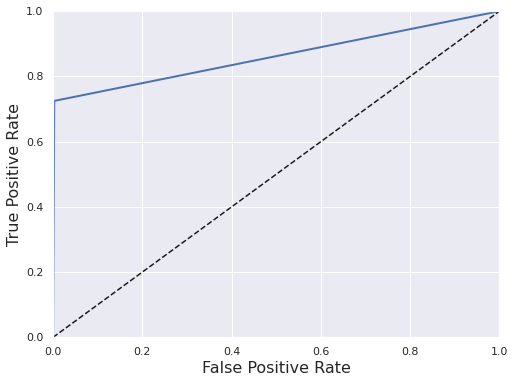

In [42]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()